<a href="https://colab.research.google.com/github/HiuNgaiChan/3dSinGAN/blob/master/FpGANVanilla2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from scipy.stats import wasserstein_distance



dataCSV = pd.read_csv('noNorm5000.csv')
dataTensor = torch.tensor(dataCSV.values).to(torch.float32)
dataTensor = torch.flatten(dataTensor)
dataTensor = dataTensor.reshape(1,dataTensor.size()[0])
batch_size = 1
dataset = torch.utils.data.DataLoader(dataTensor, batch_size=batch_size, shuffle=True)

learningRate = 0.00005

input_dim = dataTensor.size()[1]
z_size = 1000


In [3]:
class DNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.net = nn.Sequential(
          nn.Linear(input_dim,512),
          nn.ReLU(),
          #nn.Dropout(p=0.2),
          nn.Linear(512, 256),
          nn.ReLU(),
          #nn.Dropout(p=0.2),
          nn.Linear(256, 128),
          nn.ReLU(),
          #nn.Dropout(p=0.2),
          nn.Linear(128, 1),
          nn.Sigmoid()
      )


    def forward(self, x):

      return self.net(x)

class GNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.net = nn.Sequential(
          nn.Linear(z_size, 128),
          nn.ReLU(),
          nn.Linear(128, 256),
          nn.ReLU(),
          nn.Linear(256,512),
          nn.ReLU(),
          nn.Linear(512,input_dim),
          nn.Tanh()
      )
    def forward(self, x):

      return self.net(x)

In [8]:
d = DNet()
g = GNet()
lossF = nn.BCELoss()

optimizerD = optim.Adam(d.parameters(), lr=learningRate, betas = (0.5, 0.999))
optimizerG = optim.Adam(g.parameters(), lr=learningRate, betas = (0.5, 0.999))

In [ ]:
print("start training")

#emdList = []

num_epochs = 15000
#z = torch.randn(batch_size,z_size)
for epochs in range(num_epochs):
  for batch in dataset:

    #train the discriminator
    d.zero_grad()
    real_output = d(batch.view(batch.size()[0],input_dim))
    d_real_loss = lossF(real_output, torch.ones(batch.size()[0],1))

    z = torch.randn(batch.size()[0],z_size)
    g_fake = g(z)
    fake_output = d(g_fake)
    d_fake_loss = lossF(fake_output, torch.zeros(batch.size()[0],1))

    d_loss = d_real_loss + d_fake_loss
    d_loss.backward()
    optimizerD.step()

    #train the generator
    g.zero_grad()
    z = torch.randn(batch.size()[0],z_size)
    gd_output = d(g(z))
    g_loss = lossF(gd_output, torch.ones(batch.size()[0],1))
    g_loss.backward()
    optimizerG.step()

  if epochs%100 == 0:
    print("Epochs[", epochs,"]: ", " d_loss -> ",round(d_loss.item(),2), " g_loss -> ", round(g_loss.item(),2))
    #with torch.no_grad():
      #z = torch.randn(1,z_size)
      #g_output = g(z)
      #emd = wasserstein_distance(dataTensor[0].tolist(), g_output[0].tolist())
      #print("Epochs[", epochs, "]: EMD = " + str(emd))
      #emdList.append(emd)

start training
Epochs[ 0 ]:   d_loss ->  1.38  g_loss ->  0.68
Epochs[ 100 ]:   d_loss ->  0.7  g_loss ->  0.7
Epochs[ 200 ]:   d_loss ->  0.99  g_loss ->  0.52
Epochs[ 300 ]:   d_loss ->  1.04  g_loss ->  0.68
Epochs[ 400 ]:   d_loss ->  1.19  g_loss ->  0.61
Epochs[ 500 ]:   d_loss ->  1.19  g_loss ->  0.72
Epochs[ 600 ]:   d_loss ->  1.26  g_loss ->  0.77
Epochs[ 700 ]:   d_loss ->  1.39  g_loss ->  0.67
Epochs[ 800 ]:   d_loss ->  1.26  g_loss ->  0.68
Epochs[ 900 ]:   d_loss ->  1.47  g_loss ->  0.75
Epochs[ 1000 ]:   d_loss ->  1.39  g_loss ->  0.7
Epochs[ 1100 ]:   d_loss ->  1.35  g_loss ->  0.71
Epochs[ 1200 ]:   d_loss ->  1.31  g_loss ->  0.83
Epochs[ 1300 ]:   d_loss ->  1.33  g_loss ->  0.65
Epochs[ 1400 ]:   d_loss ->  1.4  g_loss ->  0.67
Epochs[ 1500 ]:   d_loss ->  1.38  g_loss ->  0.74
Epochs[ 1600 ]:   d_loss ->  1.33  g_loss ->  0.78
Epochs[ 1700 ]:   d_loss ->  1.46  g_loss ->  0.69
Epochs[ 1800 ]:   d_loss ->  1.39  g_loss ->  0.62
Epochs[ 1900 ]:   d_loss ->  1.3

In [9]:
with torch.no_grad():
    z = torch.randn(1,z_size)
    g_output = g(z)
    print(g_output[0][0:5])
    print(dataTensor[0][0:5])

tensor([0.1701, 0.8909, 0.9774, 0.6398, 0.6479])
tensor([0.3591, 0.9180, 1.0000, 0.5380, 0.7089])


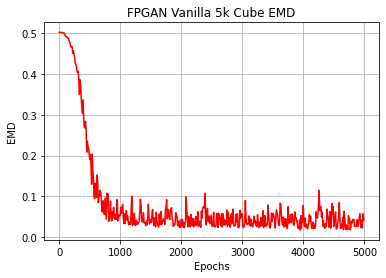

In [25]:
xis = np.arange(0,num_epochs,10)
plt.plot(xis,emdList,'r-')
plt.ylabel('EMD')
plt.xlabel('Epochs')
plt.title('FPGAN Vanilla 5k Cube EMD')
plt.grid(True)
plt.savefig("fpganVanilla5kCubeEMD.png")
plt.show()

In [23]:
#Checking if the generated point clouds are all unqiue to each other
from metrics import checkUnique

with torch.no_grad():
  record = np.zeros(10)
  for j in range(100):
    print(j)
    for i in range(10):
      z = torch.randn(1000*(i+1),z_size)
      g_output = g(z)
      g_output = g_output.numpy()
      #print(str(i+1) + " " + str(checkUnique(g_output)))
      if checkUnique(g_output) == True:
        record[i] += 1
print(record)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
[94. 77. 62. 51. 30. 26.  7.  4.  4.  0.]


In [33]:
#Generating point clouds and save them into a csv file
import csv
import torch

numModelPts = int(dataTensor.size()[1]/3)

for i in range(3):
  filename = "vanilla5kMonkey" + str(i) +".csv"
  with open(filename, "w", newline="") as csvfile:
    xyzWriter = csv.writer(csvfile, delimiter=",")
    with torch.no_grad():
      z = torch.randn(1,z_size)
      g_output = g(z)
      g_output = g_output.reshape(numModelPts,3).tolist()
      for i in range(1000):
        line = g_output[i]
        xyzWriter.writerow(line)